In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
images_path_001 = '/content/drive/MyDrive/images_001'
images_path_002 = '/content/drive/MyDrive/images_002'

def load_images_from_folder(folder):
    images = []
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img = img / 255.0
            images.append(img)
    return np.array(images)

# Load images from both folders
images_001 = load_images_from_folder(images_path_001)
images_002 = load_images_from_folder(images_path_002)

# Combine both sets of images
all_images = np.concatenate((images_001, images_002), axis=0)

# Expand dimensions to fit the CNN input (batch_size, height, width, channels)
all_images = np.expand_dims(all_images, axis=-1)

print(f"Total images loaded: {all_images.shape[0]}")

Total images loaded: 6549


In [ ]:
import numpy as np

# Save the images to a .npy file
np.save('/content/drive/MyDrive/all_images.npy', all_images)

# Load the images back from the .npy file in a new session
all_images = np.load('/content/drive/MyDrive/all_images.npy')

print(f"Loaded images: {all_images.shape}")

Loaded images: (6549, 128, 128, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from sklearn.model_selection import train_test_split

# Split the data again into new variables (optional, for time-saving purposes)
X_train_new, X_test_new = train_test_split(all_images, test_size=0.2, random_state=42)

print(f"New Training set: {X_train_new.shape}, New Test set: {X_test_new.shape}")

New Training set: (5239, 128, 128, 1), New Test set: (1310, 128, 128, 1)


In [ ]:
# Define the modified autoencoder model
def build_enhanced_autoencoder(input_shape):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder with additional convolutional layers for better detail recovery
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)  # Added extra layer
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='tanh', padding='same')(x)  # Using tanh for higher contrast

    # Build the model
    autoencoder = Model(input_img, decoded)
    return autoencoder

In [ ]:
# Define the SSIM-based loss function
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))  # 1-SSIM for minimization

# Build and compile the enhanced autoencoder
input_shape = (128, 128, 1)  # Image dimensions
enhanced_autoencoder = build_enhanced_autoencoder(input_shape)
enhanced_autoencoder.compile(optimizer='adam', loss=ssim_loss)

# Train the new model
epochs = 50 # Adjust the number of epochs as needed
batch_size = 32  # Adjust the batch size as needed
history_enhanced = enhanced_autoencoder.fit(X_train_new, X_train_new,
                                            epochs=epochs,
                                            batch_size=batch_size,
                                            validation_data=(X_test_new, X_test_new))

# Save the enhanced model
enhanced_autoencoder.save('enhanced_autoencoder.h5')

# Evaluate the new model (optional)
loss = enhanced_autoencoder.evaluate(X_test_new, X_test_new)
print(f"Test Loss with SSIM: {loss}")


Epoch 1/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - loss: 0.2466 - val_loss: 0.0958
Epoch 2/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0893 - val_loss: 0.0806
Epoch 3/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0780 - val_loss: 0.0741
Epoch 4/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0717 - val_loss: 0.0698
Epoch 5/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0675 - val_loss: 0.0659
Epoch 6/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0637 - val_loss: 0.0620
Epoch 7/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0609 - val_loss: 0.0597
Epoch 8/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0582 - val_loss: 0.0571
Epoch 9/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0558 - val_loss: 0.0553
Epoch 10/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0546 - val_loss: 0.0535
Epoch 11/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0523 - val_loss: 0.0524
Epoch 12/50
164/164 ━━━━━━━━━━━━━━━━━━━━

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0335
Test Loss with SSIM: 0.03364819288253784


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


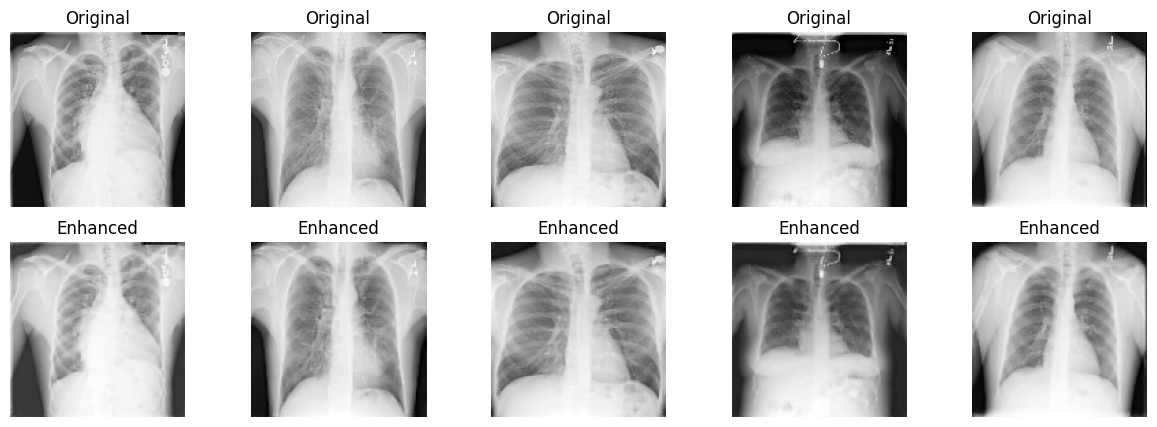

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def display_random_comparison(original, enhanced, num_images=5):
    random_indices = np.random.choice(original.shape[0], num_images, replace=False)

    plt.figure(figsize=(15, 5))

    for i, idx in enumerate(random_indices):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original[idx].reshape(128, 128), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(enhanced[idx].reshape(128, 128), cmap='gray')
        plt.title("Enhanced")
        plt.axis('off')

    plt.show()

# Generate enhanced images from the autoencoder
enhanced_images = enhanced_autoencoder.predict(X_test_new)

# Display the comparison for random test images
display_random_comparison(X_test_new, enhanced_images, num_images=5)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization

# Load the previously saved images
all_images = np.load('/content/drive/MyDrive/all_images.npy')

# Split the data into new training and testing sets
X_train_new, X_test_new = train_test_split(all_images, test_size=0.2, random_state=42)

# Define the enhanced autoencoder model with Batch Normalization and more complexity
def build_enhanced_autoencoder_v2(input_shape):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    # Using sigmoid activation for better pixel value output
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Build the model
    autoencoder = Model(input_img, decoded)
    return autoencoder

# Define the SSIM-based loss function
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

# Build and compile the enhanced autoencoder
input_shape = (128, 128, 1)  # Image dimensions
enhanced_autoencoder_v2 = build_enhanced_autoencoder_v2(input_shape)
enhanced_autoencoder_v2.compile(optimizer='adam', loss=ssim_loss)

# Train the new model
epochs = 50  # Adjust the number of epochs as needed
batch_size = 32  # Adjust the batch size as needed
history_enhanced_v2 = enhanced_autoencoder_v2.fit(X_train_new, X_train_new,
                                            epochs=epochs,
                                            batch_size=batch_size,
                                            validation_data=(X_test_new, X_test_new))

# Save the enhanced model
enhanced_autoencoder_v2.save('/content/drive/MyDrive/enhanced_autoencoder_v2.h5')

# Evaluate the new model
loss = enhanced_autoencoder_v2.evaluate(X_test_new, X_test_new)
print(f"Test Loss with SSIM: {loss}")

# Function to display random comparisons
def display_random_comparison(original, enhanced, num_images=5):
    random_indices = np.random.choice(original.shape[0], num_images, replace=False)

    plt.figure(figsize=(15, 5))

    for i, idx in enumerate(random_indices):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original[idx].reshape(128, 128), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(enhanced[idx].reshape(128, 128), cmap='gray')
        plt.title("Enhanced")
        plt.axis('off')

    plt.show()

# Generate enhanced images from the new autoencoder
enhanced_images_v2 = enhanced_autoencoder_v2.predict(X_test_new)

# Display the comparison for random test images
display_random_comparison(X_test_new, enhanced_images_v2, num_images=5)


Loaded images: (6549, 128, 128, 1)


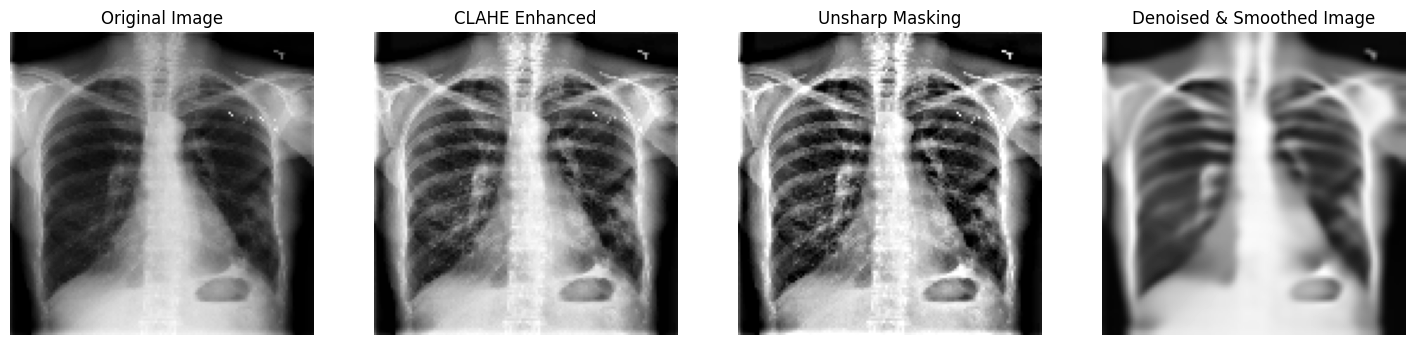

In [ ]:
!pip install opencv-python

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the images back from the .npy file in a new session
all_images = np.load('/content/drive/MyDrive/all_images.npy')

print(f"Loaded images: {all_images.shape}")

image = all_images[0].squeeze()

# Convert the image to 8-bit unsigned integer format
image_8bit = cv2.convertScaleAbs(image, alpha=(255.0/image.max()))

# Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_image = clahe.apply(image_8bit) # Pass the 8-bit image to clahe.apply()

# Apply Unsharp Masking for edge enhancement
blurred = cv2.GaussianBlur(enhanced_image, (9, 9), 10.0)
sharp_image = cv2.addWeighted(enhanced_image, 1.5, blurred, -0.5, 0)

# Apply Non-Local Means Denoising
denoised_image = cv2.fastNlMeansDenoising(sharp_image, None, 30, 7, 21)

# Optional: Apply Gaussian Filtering for smoothing
smoothed_image = cv2.GaussianBlur(denoised_image, (3, 3), 0)

# Plot the results
fig, ax = plt.subplots(1, 4, figsize=(18, 6))
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Original Image")
ax[1].imshow(enhanced_image, cmap='gray')
ax[1].set_title("CLAHE Enhanced")
ax[2].imshow(sharp_image, cmap='gray')
ax[2].set_title("Unsharp Masking")
ax[3].imshow(smoothed_image, cmap='gray')
ax[3].set_title("Denoised & Smoothed Image")

for a in ax:
    a.axis('off')

plt.show()

Epoch 1/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 31s 123ms/step - loss: 0.2242 - val_loss: 0.4331
Epoch 2/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 25s 61ms/step - loss: 0.0836 - val_loss: 0.2976
Epoch 3/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.0707 - val_loss: 0.1586
Epoch 4/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - loss: 0.0612 - val_loss: 0.0748
Epoch 5/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 0.0559 - val_loss: 0.0579
Epoch 6/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.0513 - val_loss: 0.0505
Epoch 7/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.0475 - val_loss: 0.0458
Epoch 8/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 0.0458 - val_loss: 0.0466
Epoch 9/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.0436 - val_loss: 0.0415
Epoch 10/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.0415 - val_loss: 0.0402
Epoch 11/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 0.0401 - val_loss: 0.0398
Epoch 12/50
164/164 ━━━━━━━━━━

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0239
Test Loss with SSIM: 0.023985233157873154
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
Average PSNR: 34.3741455078125 dB


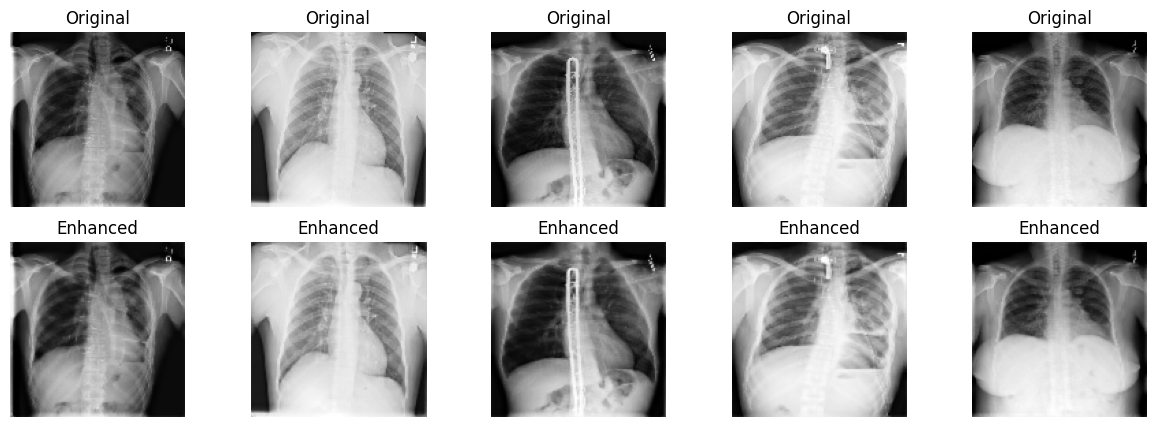

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Add
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load the previously saved images
all_images = np.load('/content/drive/MyDrive/all_images.npy')

# Split the data into new training and testing sets
X_train_new, X_test_new = train_test_split(all_images, test_size=0.2, random_state=42)

# Define a residual block for better learning
def residual_block(x):
    shortcut = x
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='linear', padding='same')(x)  # Use linear for the second layer
    x = BatchNormalization()(x)

    # Match dimensions of the shortcut and the output of the block
    shortcut = Conv2D(64, (1, 1), padding='same')(shortcut)  # Adjust shortcut to match dimensions
    return Add()([shortcut, x])  # Adding the shortcut to the output

# Define the enhanced autoencoder model with residual connections
def build_enhanced_autoencoder_v3(input_shape):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = residual_block(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Additional residual block
    x = residual_block(x)

    # Decoder
    x = UpSampling2D((2, 2))(x)
    x = residual_block(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)  # Final layer with sigmoid

    # Build the model
    autoencoder = Model(input_img, x)
    return autoencoder

# Define the SSIM-based loss function
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

# Define a function to compute PSNR
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

# Build and compile the enhanced autoencoder
input_shape = (128, 128, 1)  # Image dimensions
enhanced_autoencoder_v3 = build_enhanced_autoencoder_v3(input_shape)
enhanced_autoencoder_v3.compile(optimizer='adam', loss=ssim_loss)

# Train the new model
epochs = 50  # Adjust the number of epochs as needed
batch_size = 32  # Adjust the batch size as needed
history_enhanced_v3 = enhanced_autoencoder_v3.fit(X_train_new, X_train_new,
                                            epochs=epochs,
                                            batch_size=batch_size,
                                            validation_data=(X_test_new, X_test_new))

# Save the enhanced model
enhanced_autoencoder_v3.save('/content/drive/MyDrive/enhanced_autoencoder_v3.h5')

# Evaluate the new model
loss = enhanced_autoencoder_v3.evaluate(X_test_new, X_test_new)
print(f"Test Loss with SSIM: {loss}")

# Generate enhanced images from the new autoencoder
enhanced_images_v3 = enhanced_autoencoder_v3.predict(X_test_new)

# Compute PSNR for the enhanced images
psnr_values = psnr(X_test_new, enhanced_images_v3)
print(f"Average PSNR: {tf.reduce_mean(psnr_values)} dB")

# Function to display random comparisons
def display_random_comparison(original, enhanced, num_images=5):
    random_indices = np.random.choice(original.shape[0], num_images, replace=False)

    plt.figure(figsize=(15, 5))

    for i, idx in enumerate(random_indices):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original[idx].reshape(128, 128), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(enhanced[idx].reshape(128, 128), cmap='gray')
        plt.title("Enhanced")
        plt.axis('off')

    plt.show()

# Display the comparison for random test images
display_random_comparison(X_test_new, enhanced_images_v3, num_images=5)


205/205 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step


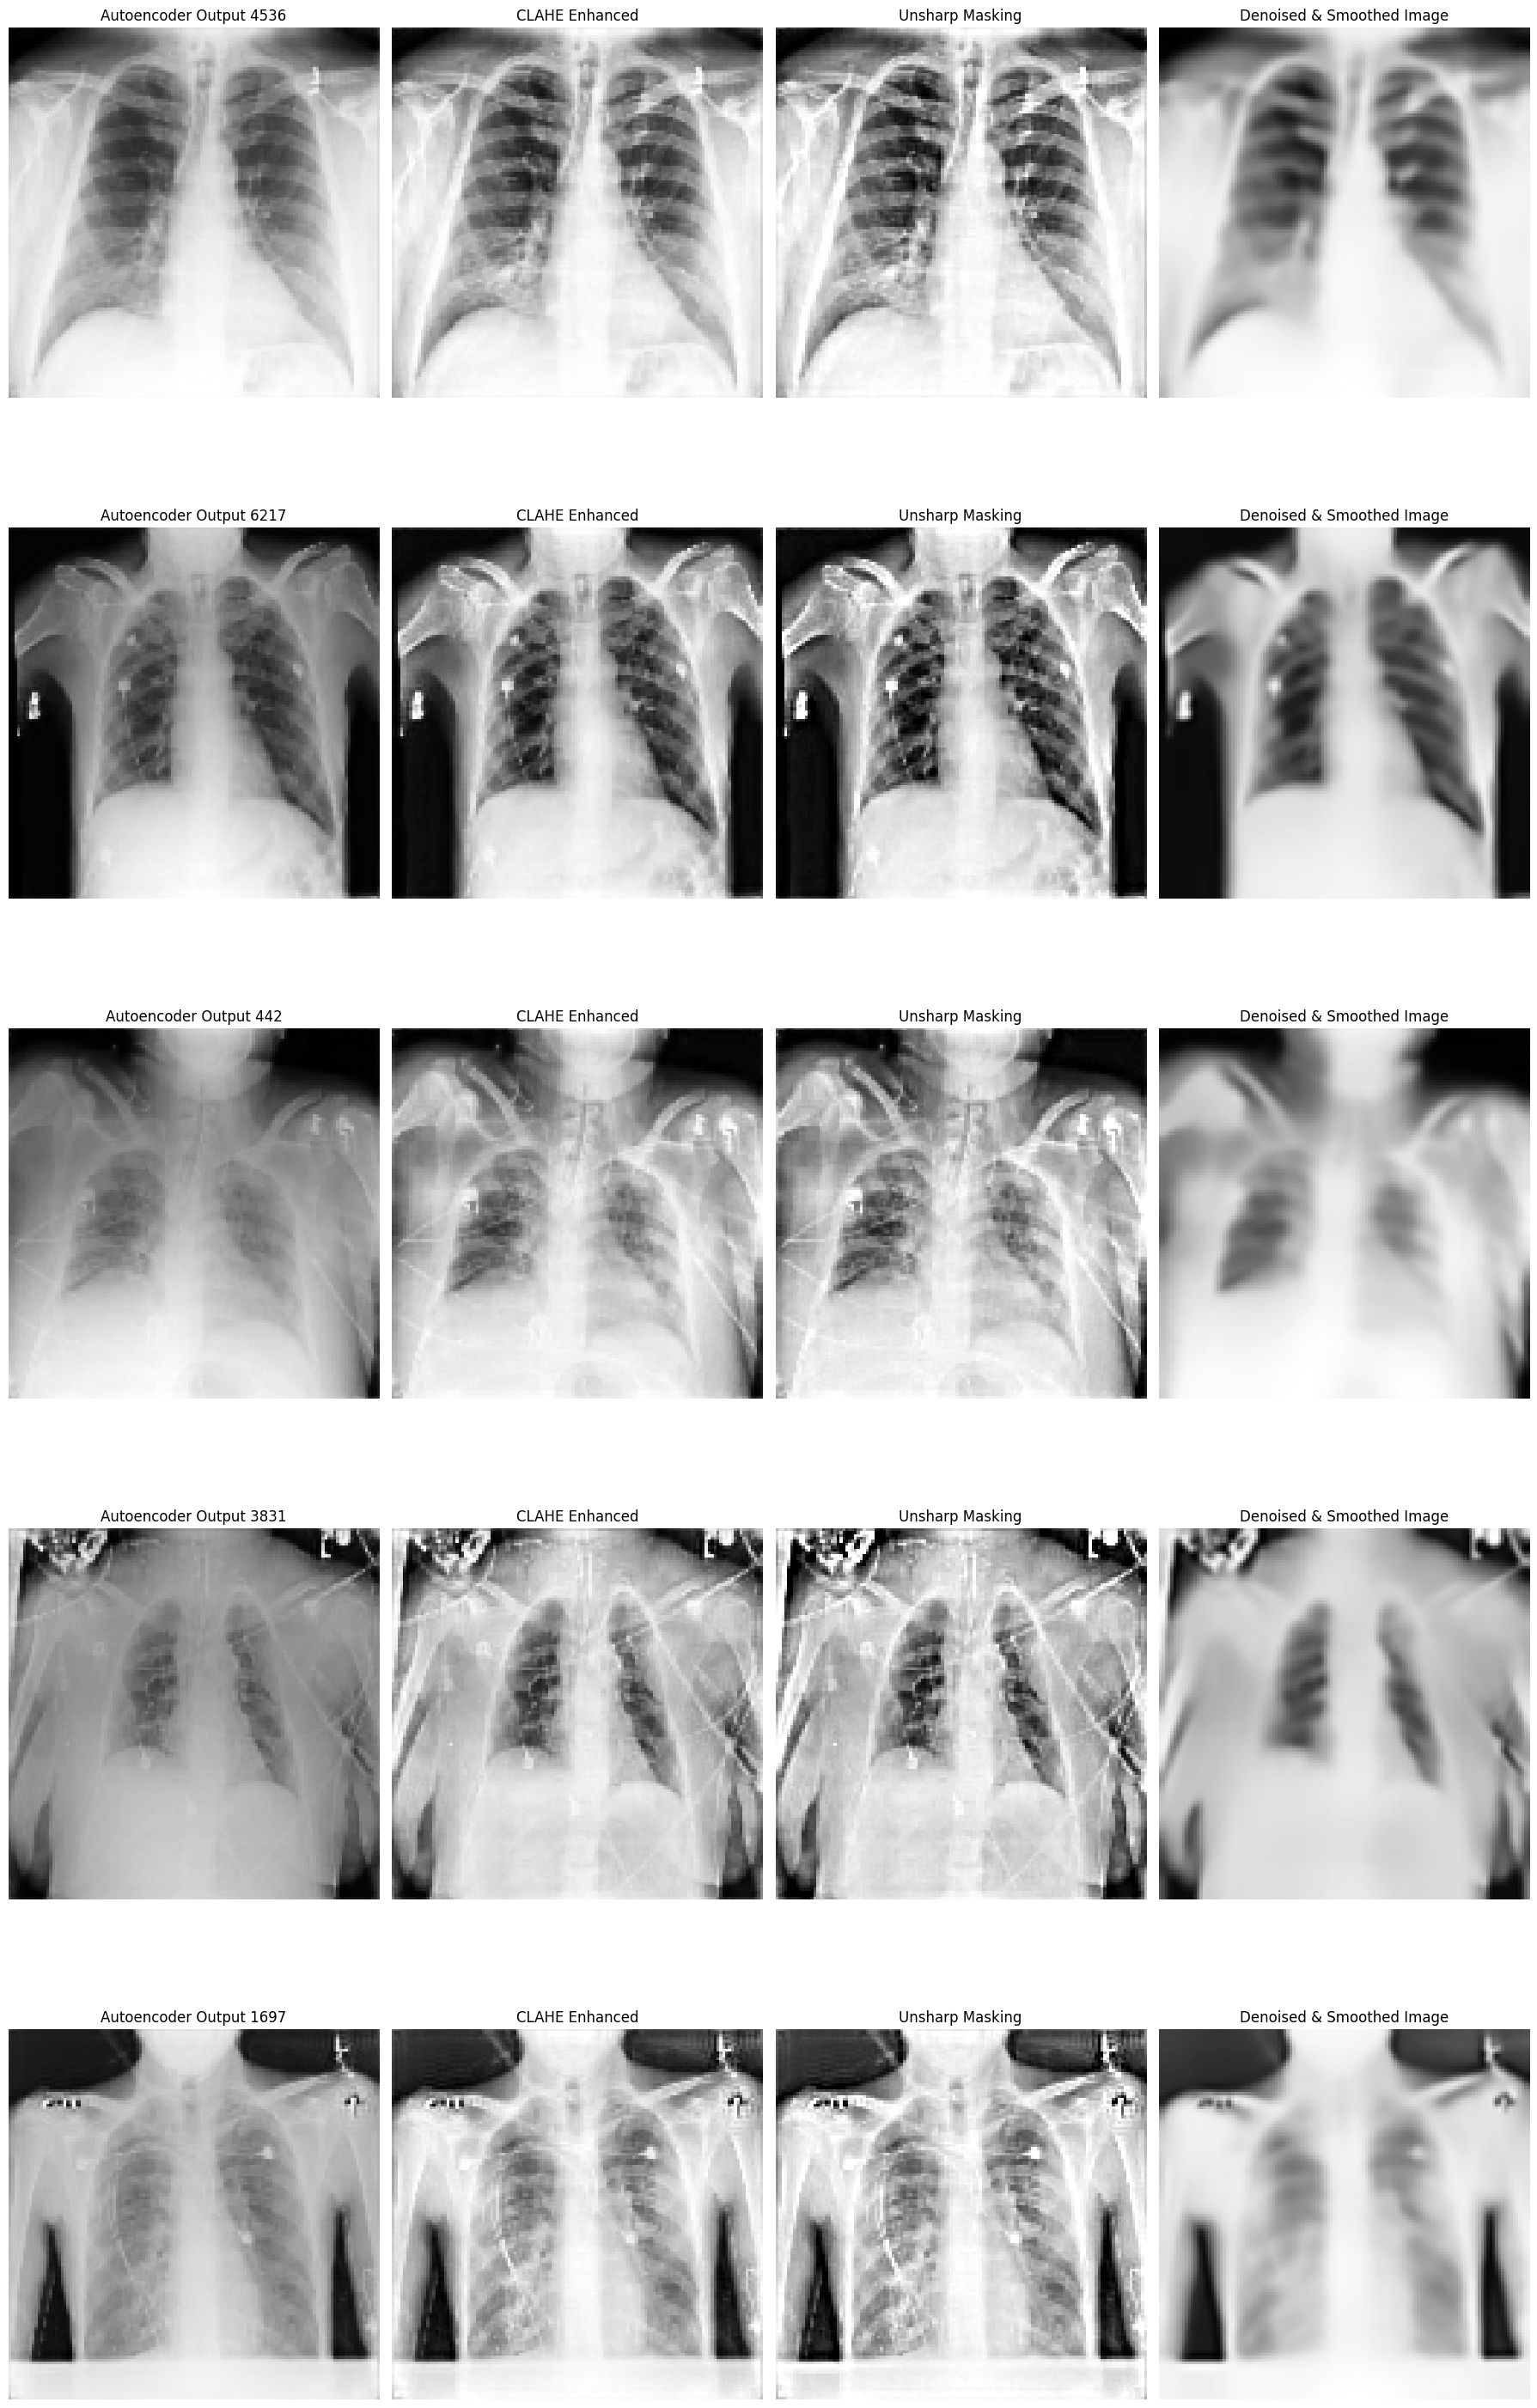

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the enhanced autoencoder version 3 model
enhanced_autoencoder_v3 = load_model('/content/drive/MyDrive/enhanced_autoencoder_v3.h5', custom_objects={'ssim_loss': ssim_loss})

# Load all images
all_images = np.load('/content/drive/MyDrive/all_images.npy')

# Generate enhanced images using the autoencoder
X_test_new = all_images  # You can use your test dataset here
enhanced_images_v3 = enhanced_autoencoder_v3.predict(X_test_new)

num_images_to_display = 5
random_indices = np.random.choice(enhanced_images_v3.shape[0], num_images_to_display, replace=False)

fig, ax = plt.subplots(num_images_to_display, 4, figsize=(18, 6 * num_images_to_display))

for i, index in enumerate(random_indices):
    image = enhanced_images_v3[index].squeeze()

    image_8bit = cv2.convertScaleAbs(image, alpha=(255.0/image.max()))

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(image_8bit)

    blurred = cv2.GaussianBlur(enhanced_image, (9, 9), 10.0)
    sharp_image = cv2.addWeighted(enhanced_image, 1.5, blurred, -0.5, 0)

    denoised_image = cv2.fastNlMeansDenoising(sharp_image, None, 30, 7, 21)

    smoothed_image = cv2.GaussianBlur(denoised_image, (3, 3), 0)

    ax[i, 0].imshow(image, cmap='gray')
    ax[i, 0].set_title(f"Autoencoder Output {index}")
    ax[i, 1].imshow(enhanced_image, cmap='gray')
    ax[i, 1].set_title("CLAHE Enhanced")
    ax[i, 2].imshow(sharp_image, cmap='gray')
    ax[i, 2].set_title("Unsharp Masking")
    ax[i, 3].imshow(smoothed_image, cmap='gray')
    ax[i, 3].set_title("Denoised & Smoothed Image")

    for j in range(4):
        ax[i, j].axis('off')

plt.tight_layout()
plt.show()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 46s 150ms/step - loss: 0.4304 - val_loss: 0.4737 - learning_rate: 0.0010
Epoch 2/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 14s 62ms/step - loss: 0.1748 - val_loss: 0.3826 - learning_rate: 0.0010
Epoch 3/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - loss: 0.1371 - val_loss: 0.2638 - learning_rate: 0.0010
Epoch 4/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - loss: 0.1215 - val_loss: 0.1322 - learning_rate: 0.0010
Epoch 5/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - loss: 0.1114 - val_loss: 0.1078 - learning_rate: 0.0010
Epoch 6/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 0.1059 - val_loss: 0.1110 - learning_rate: 0.0010
Epoch 7/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - loss: 0.1011 - val_loss: 0.0982 - learning_rate: 0.0010
Epoch 8/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - loss: 0.0979 - val_loss: 0.0949 - learning_rate: 0.0010
Epoch 9/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - loss: 0.0930 - val_loss: 0.1030 - lear

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0495
Test Loss with SSIM: 0.04973197355866432
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step
Average PSNR: 32.53089141845703 dB


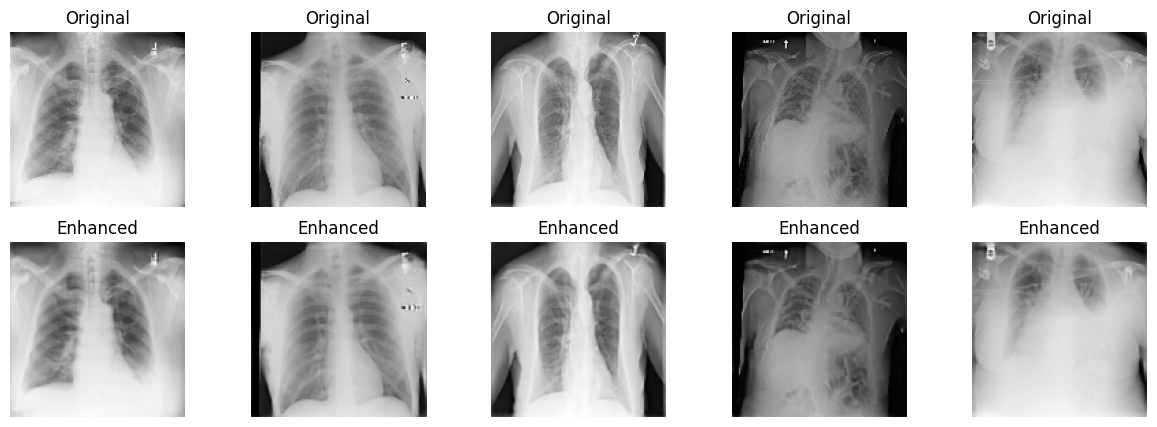

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Add, LeakyReLU
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

all_images = np.load('/content/drive/MyDrive/all_images.npy')
X_train_new, X_test_new = train_test_split(all_images, test_size=0.2, random_state=42)

def residual_block(x):
    shortcut = x
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    shortcut = Conv2D(64, (1, 1), padding='same')(shortcut)
    return Add()([shortcut, x])

def build_enhanced_autoencoder_v4(input_shape):
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), padding='same')(input_img)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = residual_block(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = residual_block(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = residual_block(x)
    x = UpSampling2D((2, 2))(x)
    x = residual_block(x)
    x = UpSampling2D((2, 2))(x)
    x = residual_block(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    autoencoder = Model(input_img, x)
    return autoencoder

def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

input_shape = (128, 128, 1)
enhanced_autoencoder_v4 = build_enhanced_autoencoder_v4(input_shape)
enhanced_autoencoder_v4.compile(optimizer='adam', loss=ssim_loss)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

epochs = 100
batch_size = 32
history_enhanced_v4 = enhanced_autoencoder_v4.fit(X_train_new, X_train_new,
                                            epochs=epochs,
                                            batch_size=batch_size,
                                            validation_data=(X_test_new, X_test_new),
                                            callbacks=[early_stopping, reduce_lr])

enhanced_autoencoder_v4.save('/content/drive/MyDrive/enhanced_autoencoder_v4.h5')

loss = enhanced_autoencoder_v4.evaluate(X_test_new, X_test_new)
print(f"Test Loss with SSIM: {loss}")

enhanced_images_v4 = enhanced_autoencoder_v4.predict(X_test_new)
psnr_values = psnr(X_test_new, enhanced_images_v4)
print(f"Average PSNR: {tf.reduce_mean(psnr_values)} dB")

def display_random_comparison(original, enhanced, num_images=5):
    random_indices = np.random.choice(original.shape[0], num_images, replace=False)
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(random_indices):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original[idx].reshape(128, 128), cmap='gray')
        plt.title("Original")
        plt.axis('off')
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(enhanced[idx].reshape(128, 128), cmap='gray')
        plt.title("Enhanced")
        plt.axis('off')
    plt.show()

display_random_comparison(X_test_new, enhanced_images_v4, num_images=5)


41/41 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step


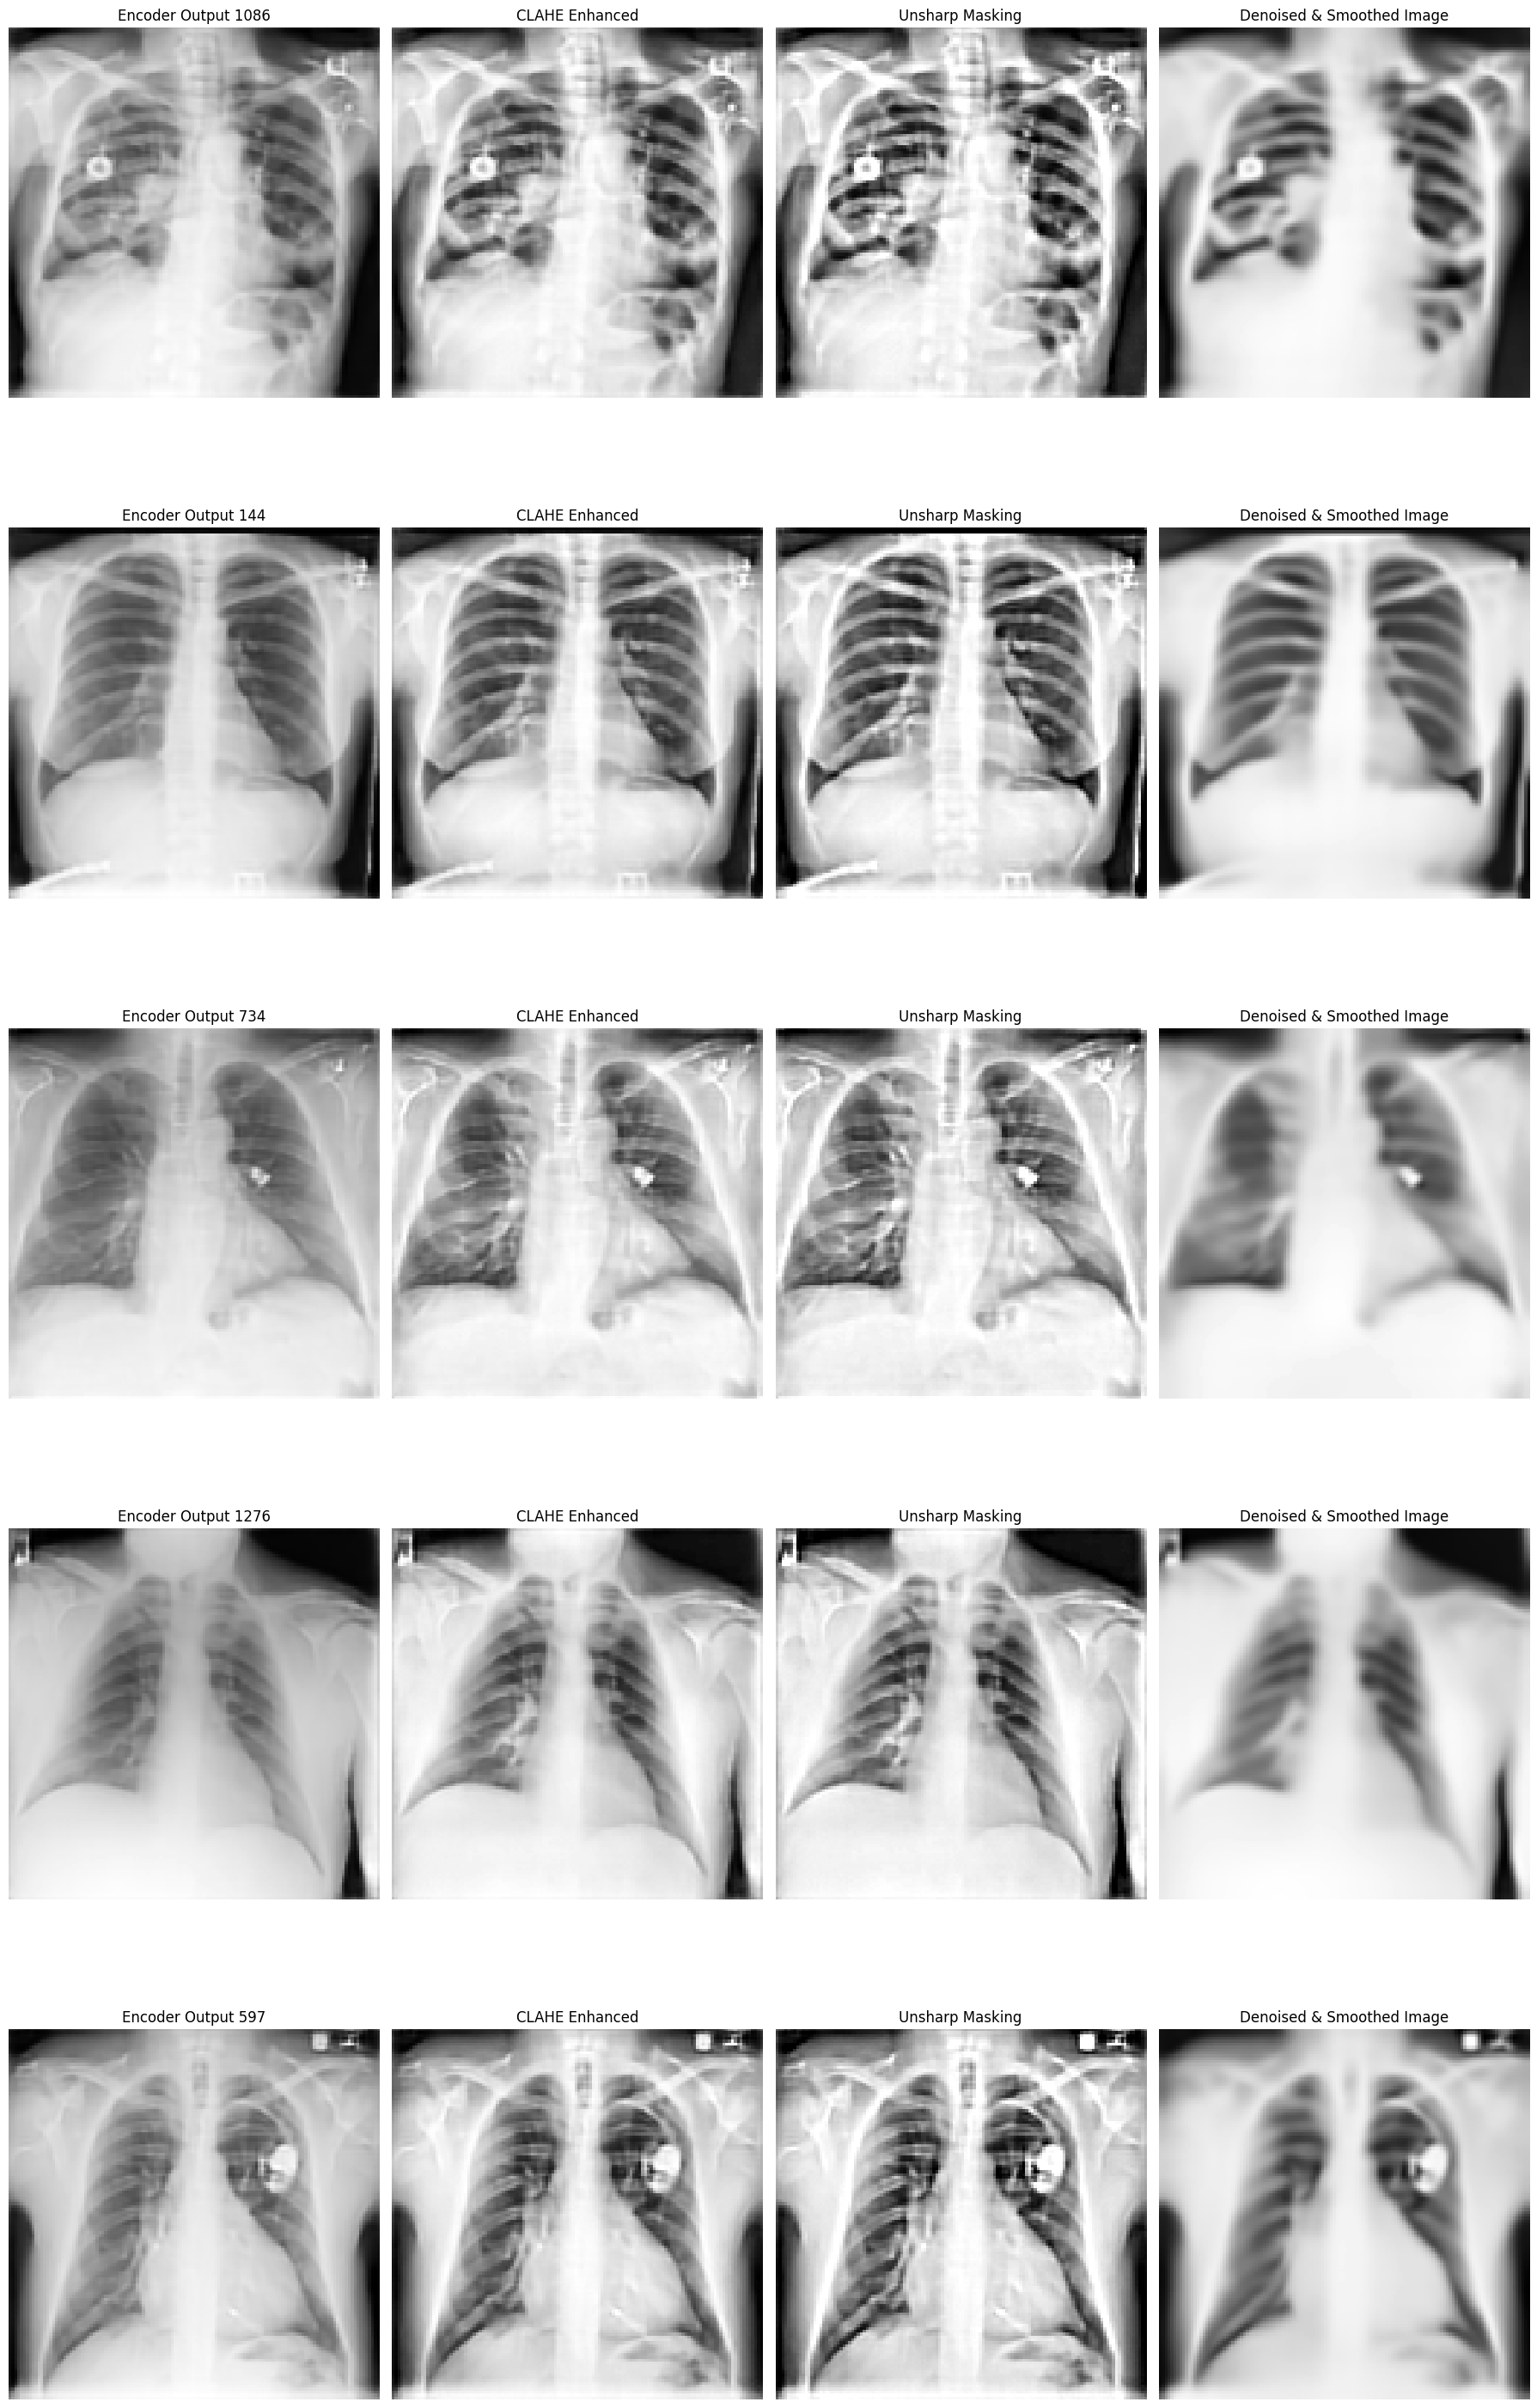

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

# Define the SSIM-based loss function
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

# Load the models
#enhanced_autoencoder_v3 = load_model('/content/drive/MyDrive/enhanced_autoencoder_v3.h5', custom_objects={'ssim_loss': ssim_loss})
enhanced_autoencoder_v4 = load_model('/content/drive/MyDrive/enhanced_autoencoder_v4.h5', custom_objects={'ssim_loss': ssim_loss})

# Load the data and split it into train and test sets
all_images = np.load('/content/drive/MyDrive/all_images.npy')  # Load your data here
X_train_new, X_test_new = train_test_split(all_images, test_size=0.2, random_state=42)
# Generate enhanced images
enhanced_images_v4 = enhanced_autoencoder_v4.predict(X_test_new)

num_images_to_display = 5
random_indices = np.random.choice(enhanced_images_v4.shape[0], num_images_to_display, replace=False)

fig, ax = plt.subplots(num_images_to_display, 4, figsize=(18, 6 * num_images_to_display))

for i, index in enumerate(random_indices):
    image = enhanced_images_v4[index].squeeze()

    image_8bit = cv2.convertScaleAbs(image, alpha=(255.0/image.max()))

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(image_8bit)

    blurred = cv2.GaussianBlur(enhanced_image, (9, 9), 10.0)
    sharp_image = cv2.addWeighted(enhanced_image, 1.5, blurred, -0.5, 0)

    denoised_image = cv2.fastNlMeansDenoising(sharp_image, None, 30, 7, 21)

    smoothed_image = cv2.GaussianBlur(denoised_image, (3, 3), 0)

    ax[i, 0].imshow(image, cmap='gray')
    ax[i, 0].set_title(f"Encoder Output {index}")
    ax[i, 1].imshow(enhanced_image, cmap='gray')
    ax[i, 1].set_title("CLAHE Enhanced")
    ax[i, 2].imshow(sharp_image, cmap='gray')
    ax[i, 2].set_title("Unsharp Masking")
    ax[i, 3].imshow(smoothed_image, cmap='gray')
    ax[i, 3].set_title("Denoised & Smoothed Image")

    for j in range(4):
        ax[i, j].axis('off')

plt.tight_layout()
plt.show()
